In [86]:
!pip install torch 

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/7b/7c/4d8728e6f8dbe2b8af054bd92c290d94c633270443514e3ee4b768125cf9/torch-2.1.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Using cached torch-2.1.0-cp311-none-macosx_11_0_arm64.whl.metadata (24 kB)
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/ea/c8/407364710cb9631ce306a97abff2d61836d603b258b5e5399b5f12a7f787/filelock-3.13.0-py3-none-any.whl.metadata
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/e8/f6/3eccfb530aac90ad1301c582da228e4763f19e719ac8200752a4841b0b2d/fsspec-2023.10.0-py3-none-any.whl.metadata
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 808.0 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 1.2 MB/s eta 0:00:00a 0:00:01


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import networkx as nx
import random
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

In [2]:
data = pd.read_csv("KS_system/KS_L=44_tf=10000_dt=.25_D=64.csv", skiprows=1, header=None).to_numpy()

In [3]:
sliced_data = data[:1000, :]

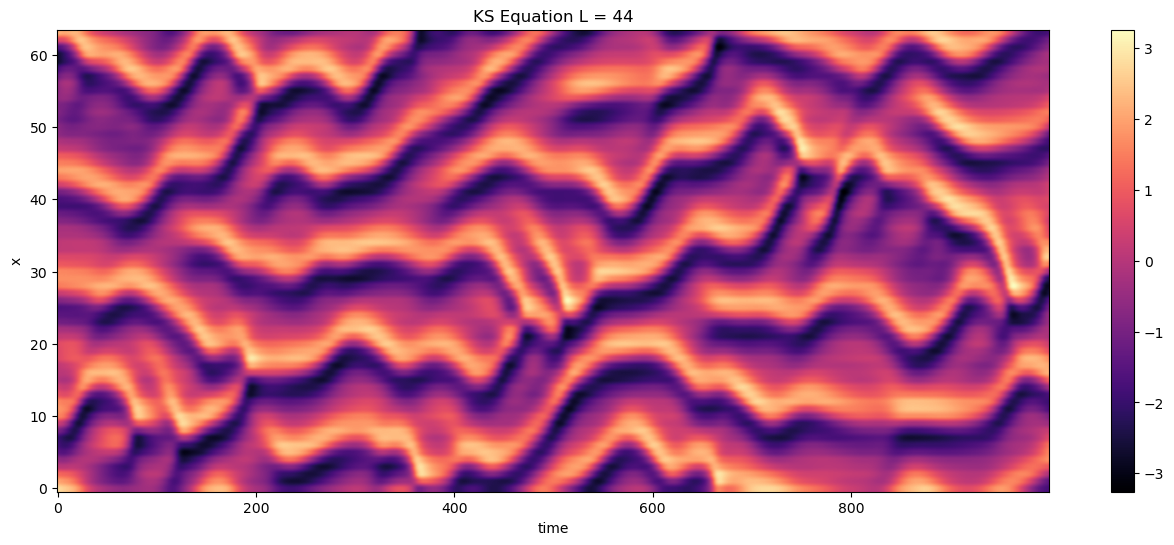

In [4]:
plt.figure(figsize=(16, 6))
c = plt.imshow(sliced_data.T, cmap ='magma', aspect='auto', origin = "lower")
plt.colorbar(c) 
plt.title("KS Equation L = 44") 
plt.xlabel("time")
plt.ylabel("x")
plt.show() 

In [5]:
sampled_data = sliced_data[::10, :]

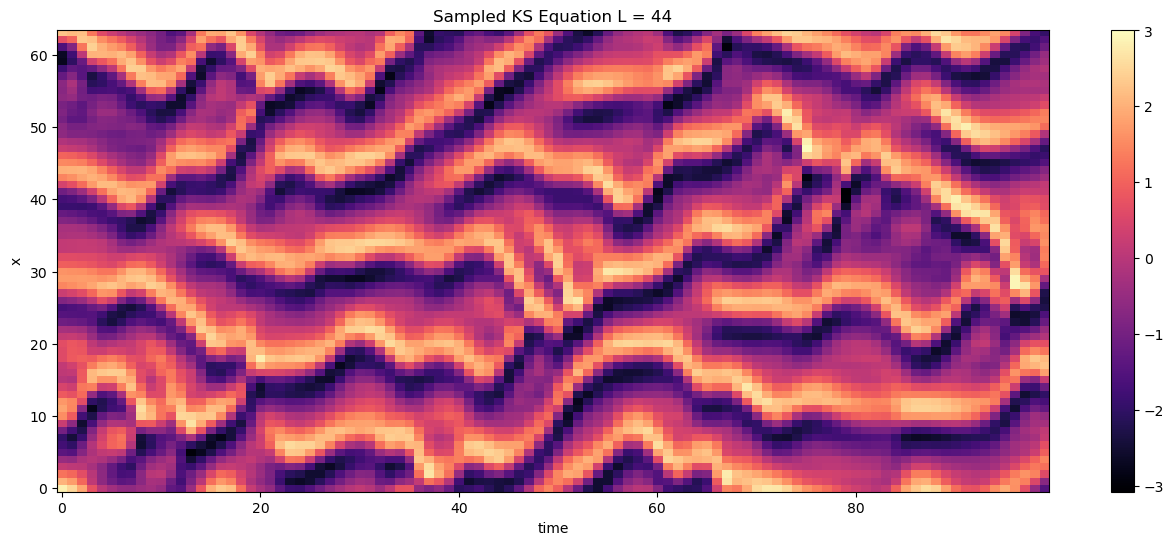

In [6]:
plt.figure(figsize=(16, 6))
d = plt.imshow(sampled_data.T, cmap ='magma', aspect='auto', origin = "lower")
plt.colorbar(d) 
plt.title("Sampled KS Equation L = 44") 
plt.xlabel("time")
plt.ylabel("x")
plt.show() 

#### RC

In [7]:
def generate_reservoir(dim_reservoir, rho, density):
    graph = nx.gnp_random_graph(dim_reservoir, density)
    array = nx.to_numpy_array(graph)
    rand = 2 * (np.random.rand(dim_reservoir) - 0.5)
    res = array * rand
    return scale_res(res, rho)

def scale_res(A, rho):
    eigvalues, eigvectors = np.linalg.eig(A)
    max_eig = np.amax(eigvalues)
    max_length = np.absolute(max_eig)
    if max_length == 0:
        raise ZeroDivisionError("Max of reservoir eigenvalue lengths cannot be zero.")
    return rho * A / max_length

def lin_reg(R, U, beta=0.0001):
    
    Rt = np.transpose(R)
    W_out = np.matmul(np.matmul(np.transpose(U), Rt), np.linalg.inv(np.matmul(R, Rt) + beta * np.identity(R.shape[0])))

    return W_out

def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def relu(x):
    return np.where(x >= 0, x, 0)

def correlation_distance(traj, x_idx):
    num_gridpoints = traj.shape[1]
    temp = np.tile(traj, (num_gridpoints, 1, 1))
    temp2 = np.transpose(traj)
    u_t_temp = temp2 - np.mean(temp, axis=2)
    var_temp = np.sum(u_t_temp * u_t_temp, axis=0)

    x_idx = x_idx % num_gridpoints
    if x_idx == 0:
        u_tau_temp = u_t_temp
    else:
        u_tau_temp = np.concatenate([u_t_temp[x_idx:], u_t_temp[:x_idx]], axis=0)
    
    covar_temp = np.sum(u_t_temp * u_tau_temp, axis=0)

    correlation_distance_vec = covar_temp / var_temp
    return correlation_distance_vec

In [8]:
class MemorylessReservoirComputer:
    def __init__(self, dim_system=3, dim_reservoir=300, delta=0.05102, in_density=0.4, beta=2.1544e-5):
        self.dim_reservoir = dim_reservoir
        self.dim_system = dim_system
        self.beta = beta
        self.r_state = np.zeros(dim_reservoir)
        W_in = 2 * delta * (np.random.rand(dim_reservoir, dim_system) - 0.5)
        self.W_in = np.where(np.random.rand(dim_reservoir, dim_system) <= in_density, W_in, 0)
        self.W_out = np.zeros((dim_system, 2 * dim_reservoir + 1))
    
    def advance(self, u):
        """
        Generate the next r_state given an input u and the current r_state
        """
        
        self.r_state = sigmoid(np.dot(self.W_in, u))
        
    def readout(self):
        """
        Generate and return the prediction v given the current r_state
        """

        r_temp = np.concatenate([self.r_state, self.r_state**2, np.array([1])])
        v = np.dot(self.W_out, r_temp)
        return v
    
    def train(self, traj):
        """
        Optimize W_out so that the network can accurately model the given trajectory.
        
        Parameters
        traj: The training trajectory stored as a (n, dim_system) dimensional numpy array, where n is the number of timesteps in the trajectory
        """
        R = np.zeros((self.dim_reservoir, traj.shape[0]))
        for i in range(traj.shape[0]):
            R[:, i] = self.r_state
            x = traj[i]
            self.advance(x)
        
        R = np.concatenate([R, R**2, np.ones((1, traj.shape[0]))])
        self.W_out = lin_reg(R, traj, self.beta)
        #print("train loss: {}".format(np.mean((self.W_out @ R - traj.transpose())**2)))
        
    def predict(self, steps):
        """
        Use the network to generate a series of predictions
        
        Parameters
        steps: the number of predictions to make. Can be any positive integer
        
        Returns
        predicted: the predicted trajectory stored as a (steps, dim_system) dimensional numpy array
        """
        predicted = np.zeros((steps, self.dim_system))
        for i in range(steps):
            v = self.readout()
            predicted[i] = v
            self.advance(v)
        return predicted

In [9]:
class ReservoirComputer(MemorylessReservoirComputer):
    def __init__(self, dim_system=3, dim_reservoir=300, delta=0.1, in_density=0.2, rho=1.1, density=0.05, beta=0.0001):
        super().__init__(dim_system=dim_system, dim_reservoir=dim_reservoir, delta=delta, in_density=in_density, beta=beta)
        self.A = generate_reservoir(dim_reservoir, rho, density)
    
    def advance(self, u):
        """
        Generate the next r_state given an input u and the current r_state
        """
        
        self.r_state = sigmoid(np.dot(self.A, self.r_state) + np.dot(self.W_in, u))

In [10]:
class CMRC(nn.Module):
    def __init__(self, n, sub_length, padding, sigma=0.1):
        super(CMRC, self).__init__()
        self.n = n
        self.sub_length = sub_length
        self.padding = padding

        W_in = 2 * sigma * (np.random.rand(n, sub_length + 2 * padding) - 0.5)
        self.conv = nn.Conv1d(1, n, sub_length + 2 * padding, stride=sub_length, bias=False).type(torch.double)
        self.conv.weight.data = torch.tensor(W_in, dtype=torch.double).unsqueeze(1)
        self.conv2 = nn.Conv1d(2 * n, sub_length, 1, stride=1, bias=False).type(torch.double)
        self.sig = nn.Sigmoid()
    
    def generate_r_states(self, traj):
        with torch.no_grad():
            num_samples = traj.shape[0]
            r_states = self.conv(traj) # out is (num_samples, n, len_state_vector // sub_length)
            r_states = self.activation(r_states)
            self.r_state = r_states[-1].unsqueeze(0)

            num_subwindows = r_states.shape[2]
            r_states = r_states.transpose(1, 2).reshape((num_samples * num_subwindows, 2 * self.n))
            self.training_states = torch.cat([torch.zeros((num_subwindows, 2 * self.n)), r_states[:r_states.shape[0] - num_subwindows]], dim=0)
    
    def train_normal_eq(self, target):
      
        U = target.cpu().numpy()
        R = self.training_states.cpu().numpy().transpose()
        W_out = lin_reg(R, U, 4.641e-4)
        self.conv2.weight.data = torch.tensor(W_out, dtype=torch.double).unsqueeze(2)

    def readout(self):
        with torch.no_grad():
            pred = self.conv2(self.r_state).transpose(1, 2).flatten()
            if self.padding > 0:
                assisted_vec = torch.cat([pred[pred.shape[0] - self.padding:], pred, pred[:self.padding]])
            else:
                assisted_vec = pred
            
            return pred, assisted_vec

    def advance(self, assisted_vec):
        with torch.no_grad():
            out = self.conv(assisted_vec.unsqueeze(0).unsqueeze(0))
            self.r_state = self.activation(out)
    
    def activation(self, x):
        x = self.sig(x)
        x = torch.cat([x, x**2], dim=1)
        return x

    def predict(self, steps):
        pred_list = []
        for i in range(steps):
            pred, assisted_vec = self.readout()
            pred_list.append(pred.detach().cpu().numpy())
            self.advance(assisted_vec)
        predicted = np.stack(pred_list)
        return predicted

In [11]:
def train(model, dataloader, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.5)
    loss_f = nn.MSELoss()
    model.train()
    epoch_loss_list = []
    fig, ax = plt.subplots(1)
    for e in range(epochs):
        cum_loss = 0
        for i, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            out = model(x)
            loss = loss_f(out, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                cum_loss += loss
            # if i % 10 == 0 and i != 0:
            #     scheduler.step()
        if e % 50 == 0:
            print("Epoch {} complete".format(e))
            epoch_loss_list.append((cum_loss / i).item())

            ax.clear()
            ax.plot(epoch_loss_list)
            plt.savefig("GD_training_loss.png")

In [12]:
# Parameters
L = 44
N = 64
dt = 0.025

partitioning data
instantiating models
train models
forecasting
generating visualizations


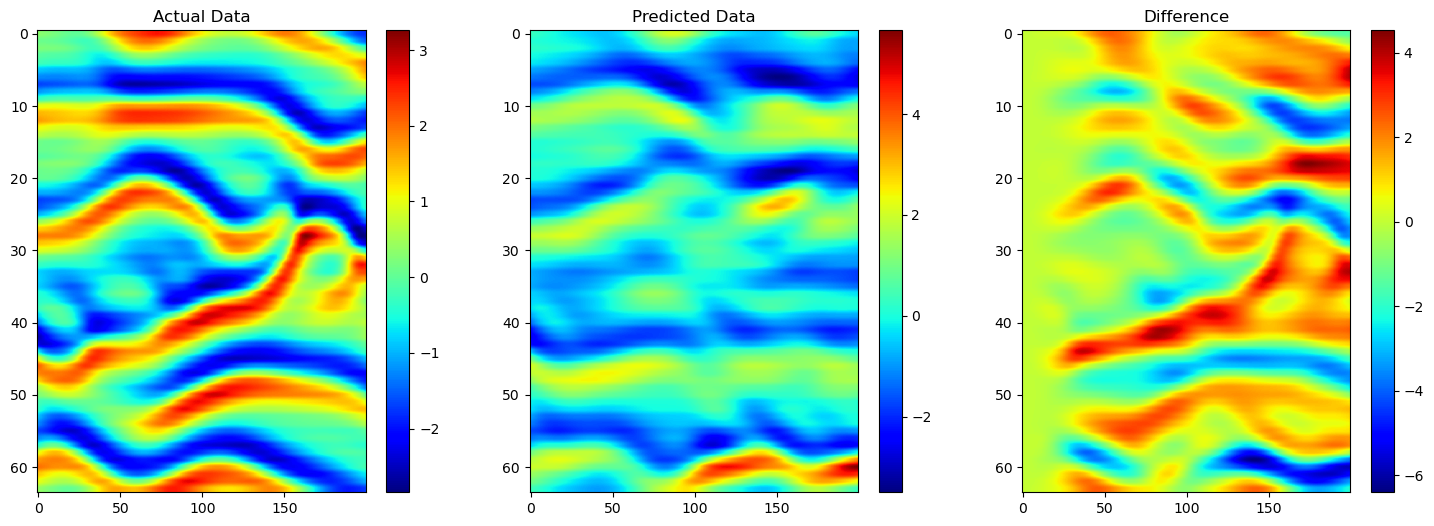

In [64]:
"""
Partition Data
"""
print("partitioning data")
train_size = int(0.8 * len(sliced_data))
train_data = sliced_data[:train_size]
test_data = sliced_data[train_size:]

"""
Instantiate Models
"""
print("instantiating models")
dim_system = N
dim_reservoir = 4000
rho = .9    
sigma = 0.3      
density = 0.05 

mrc = MemorylessReservoirComputer(dim_system, dim_reservoir)

"""
Train Models
"""
print("train models")
mrc.train(train_data)

"""
Forecast
"""
print("forecasting")
forecast_steps = len(test_data)
predictions_rc = mrc.predict(forecast_steps)
difference = test_data - predictions_rc
"""
Visualize Predictions
"""
print("generating visualizations")
# Create a figure and a grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot actual data
cax0 = ax[0].imshow(test_data.T, aspect='auto', cmap='jet')
ax[0].set_title('Actual Data')
fig.colorbar(cax0, ax=ax[0])

# Plot predicted data
cax1 = ax[1].imshow(predictions_rc.T, aspect='auto', cmap='jet')
ax[1].set_title('Predicted Data')
fig.colorbar(cax1, ax=ax[1])

# Plot difference
cax2 = ax[2].imshow(difference.T, aspect='auto', cmap='jet')
ax[2].set_title('Difference')
fig.colorbar(cax2, ax=ax[2])

# Show the plot
plt.show()

In [14]:
padding = 8
sub_length = 8
n = 375
dt = 0.25

In [15]:
def KS_to_torch(train_data, padding, sub_length):
    # sub length must divide train_data.shape[1]
    training_traj = torch.tensor(train_data, dtype=torch.double)
    if padding > 0:
        training_traj = torch.cat([training_traj[:, training_traj.shape[1] - padding:], training_traj, training_traj[:, :padding]], dim=1)
    training_traj = training_traj.unsqueeze(1)
    target = torch.tensor(train_data, dtype=torch.double).reshape((-1, sub_length))
    return training_traj, target

class KS_Dataset(Dataset):
    def __init__(self, traj, padding, sub_length):
        """
        traj is np array
        """
        self.sub_length = sub_length
        self.padding = padding
        self.training_traj, _ = KS_to_torch(traj, padding, sub_length)
        self.last_vec = self.training_traj[-1]
        self.num_windows = (self.training_traj.shape[2] - 2 * self.padding) // sub_length
    
    def __len__(self,):
        return self.training_traj.shape[0] - 1
    
    def __getitem__(self, idx):
        return self.training_traj[idx], self.training_traj[idx + 1, :, self.padding:self.training_traj.shape[2] - self.padding]

In [16]:
training_traj, target = KS_to_torch(train_data, padding, sub_length)

In [17]:
print("data generated.")

print("instantiating model...")
model = CMRC(n, sub_length, padding, sigma=0.1)

print("generating training r_states...")
model.generate_r_states(training_traj)
print("fitting model...")
model.train_normal_eq(target)


assisted_vec = np.concatenate([train_data[-1, test_data.shape[1] - padding:], train_data[-1], train_data[-1, :padding]])
assisted_vec = torch.tensor(assisted_vec, dtype=torch.double)
model.advance(assisted_vec)
predicted = model.predict(test_data.shape[0])

data generated.
instantiating model...
generating training r_states...
fitting model...


In [107]:
difference_torch = test_data - predicted

generating visualizations


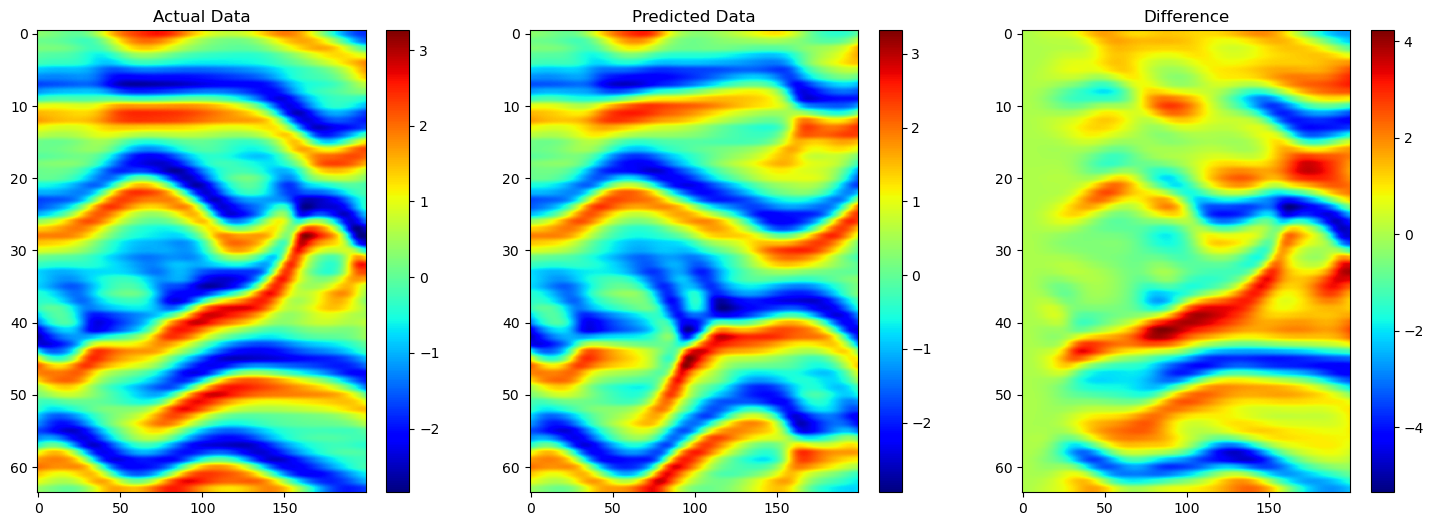

In [108]:
"""
Visualize Predictions
"""
print("generating visualizations")
# Create a figure and a grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot actual data
cax0 = ax[0].imshow(test_data.T, aspect='auto', cmap='jet')
ax[0].set_title('Actual Data')
fig.colorbar(cax0, ax=ax[0])

# Plot predicted data
cax1 = ax[1].imshow(predicted.T, aspect='auto', cmap='jet')
ax[1].set_title('Predicted Data')
fig.colorbar(cax1, ax=ax[1])

# Plot difference
cax2 = ax[2].imshow(difference.T, aspect='auto', cmap='jet')
ax[2].set_title('Difference')
fig.colorbar(cax2, ax=ax[2])

# Show the plot
plt.show()